# Location modeling for microbiome colonization

$$
\begin{align}
\min_{v^k,y^k} \quad & -\sum_k \sum_j c_k^T v^k_j \\
\mathrm{s.t.}  \quad & S^k v^k_j = 0, \quad j \in \mathrm{Locations} \\
                     & \sum_j y^k_j \leq X^k_0 + X^k_0 \mu^k T_c \\
                     & l^k_j y^k_j \leq v^k_j \leq u^k_j y^k_j \\
                     & \sum_k y^k_j \leq 1, \quad j\in \mathrm{Locations} \\
                     & v^k_{lj} \geq \sum_i \frac{v^\mathrm{tot}_{lij}}{d_{ij}} + \sum_{p\neq j} \frac{v^\mathrm{synth}_{lp}}{d_{jp}}, \quad l\in \mathrm{Nutrients},\ j\in \mathrm{Locations},\ k\in \mathrm{Organisms} \\
                     & v^\mathrm{tot}_{il} \leq \sum_k \sum_j v^k_{lij} d_{ij}, \quad l\in \mathrm{Nutrients},\ i\in \mathrm{Sources} \\
                     & y^k_j \in \{0,1\}.
\end{align}
$$

## Recapitulate:
http://www.pnas.org/content/early/2017/10/04/1711596114.short
- macro-scale patterns:
    - [Fig 2A,B](http://www.pnas.org/content/pnas/early/2017/10/04/1711596114/F4.large.jpg)
- microhabitats composition (dominant):
    - dominant species: Bacteroides dominate all microhabitats
        - Bacteroides: 43% of densely colonized and 46% of sparsely colonized fields
        - C. aerofaciens: 11% in densely, 6% in sparsely
        - C. scindens: 8% in both
        - R. torques: 3% in dense, 2% in sparse    
- inter-taxa correlations ([Fig. S3](http://www.pnas.org/content/pnas/early/2017/10/04/1711596114/F9.large.jpg))
    - some species show negative correlation
    - but R^2 small and p-values not reported!
- micro-scale spatial patterns (numbers are for mouse)
    - proximal colon shows homogenized community due to mixing and dispersal by host factors
    - turnover for mucus is 6 h for mucus in goblet cells and 1 h for inner mucus layer in distal colon
    - replication time of B. thetaiotaomicron and E. coli is 3 h in mucus layer and 3-8 h in colonic contents
    - therefore, microbes divide only a few rounds before being shed along with mucus into lumen
    - gut contents traverse mouse intestine in 4-6 h
    - overall, the turnover and shedding diminishes/disrupts segregated communities and spatial structure
    - note: human dental plaque form clustered and ordered arrangements

### Bacteria:
http://www.pnas.org/content/early/2017/10/04/1711596114.short
- 6 species (in [AGORA](https://vmh.uni.lu/#downloadview)?):
    - Bacteroides cellulosilyticus (yes, DSM 14838)
    - Bacteroides caccae (yes, ATCC 43185)
    - Parabacteroides distasonis (yes, ATCC 8503)
    - Ruminococcus torques (yes, ATCC 27756, L2-14)
    - Clostridium scindens (yes, ATCC 35704)
    - Collinsella aerofaciens (yes, ATCC 25986)
- 4 Moderately abundant Bacteroides:
    - Bacteroides thetaiotaomicron (yes, VPI-5482)
    - Bacteroides vulgatus (yes, ATCC 8482)
    - Bacteroides ovatus (yes, ATCC 8483, SD CC 2a, SD CMC 3f)
    - Bacteroides uniformis (yes, ATCC 8492)
- 5 low abundance Firmicutes
    - Eubacterium rectale (yes, ATCC 33656, M104/1)
    - Clostridium spiroforme (yes, DSM 1552)
    - Faecalibacterium prausnitzii ()yes, L2-6
    - Ruminococcus obeum (yes, A2-162)
    - Dorea longicatena (yes, DSM 13814)

## Grid

In [1]:
from gurobipy import *

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['svg.fonttype'] = 'none'
pd.set_option('display.max_colwidth', -1)
%matplotlib inline

from cobra.io import load_json_model
from six import iteritems
import numpy as np
import cobra

In [2]:
ijomc = load_json_model('/home/laurence/ME/models/e_coli_core_pc.json')

In [3]:
from cobra.io.sbml3 import read_sbml_model

def repair_model(mdl):
    obj0 = mdl.optimize().f
    for rxn in mdl.reactions:
        rxn.id = rxn.id.replace('__40__','_').replace('__41__','')
    for met in mdl.metabolites:
        met.id = met.id.replace('__91__','_').replace('__93__','')
    mdl.repair()
    obj1 = mdl.optimize().f
    print('mu: before=%s. after=%s' % (obj0,obj1))
    assert abs(obj1-obj0)<1e-9

B_caccae = read_sbml_model('/home/laurence/ME/data/microbiome/Agora_1_02_Western/sbml/Bacteroides_caccae_ATCC_43185.xml')
repair_model(B_caccae)
B_cell = read_sbml_model('/home/laurence/ME/data/microbiome/Agora_1_02_Western/sbml/Bacteroides_cellulosilyticus_DSM_14838.xml')
repair_model(B_cell)

mu: before=0.527200385031. after=0.527200385031
mu: before=0.337029885021. after=0.337029885021


In [4]:
models = [B_caccae, B_cell]

In [5]:
for mdl in models:
    for rxn in mdl.reactions:
        if rxn.objective_coefficient != 0:
            print('mdl=%s. rxn=%s. objcoeff=%s' % (mdl.id, rxn.id, rxn.objective_coefficient))

mdl=Bacteroides_caccae_ATCC_43185. rxn=biomass536. objcoeff=1.0
mdl=Bacteroides_cellulosilyticus_DSM_14838. rxn=biomass536. objcoeff=1.0


In [6]:
data = {'id':[B_caccae.id, B_cell.id],
        'j0':[0,2],
        'X0':[1,1],
        'biomass':['biomass536', 'biomass536']
}
df_organism = pd.DataFrame.from_dict(data)
df_organism

,X0,biomass,id,j0
0,1,biomass536,Bacteroides_caccae_ATCC_43185,0
1,1,biomass536,Bacteroides_cellulosilyticus_DSM_14838,2


## Toy spatial constraints

In [7]:
## Location relative distances
xy_dict = {0:(0,0),
           1:(1,0),
           2:(2,0),
           3:(1,1),
           4:(0,2),
           5:(1,2),
           6:(2,2)}
rows = []
for i in range(7):
    for j in range(7):
        xi,yi = xy_dict[i]
        xj,yj = xy_dict[j]
        dx = xj-xi
        dy = yj-yi
        d  = np.sqrt(dx**2 + dy**2)
        rows.append({'i':i, 'j':j, 'd':d})
df_loc = pd.DataFrame(rows)

In [8]:
## Primary sources
r2 = 2**0.5
r5 = 5**0.5
data = {'i':[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        'j':[0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6],
        'd':[1, r2,r5,1, 1, r2,r5,r5,r2,1, 1, r5,r2,1]}
df_sources = pd.DataFrame.from_dict(data)

In [9]:
## Nutrient uptake capacities
data = {'i':[0,1],
        'l':['cellb_e', 'acgal_e'], # cellobiose and an O-glycan
        'vtot':[-2, -1],
        'x':[0,2],
        'y':[1,1]
       }   
df_nutrient = pd.DataFrame.from_dict(data)

In [10]:
df_nutrient

,i,l,vtot,x,y
0,0,cellb_e,-2,0,1
1,1,acgal_e,-1,2,1


In [11]:
## Nutrient to exchange flux mapping for organisms
rows = []
for i,row in df_nutrient.iterrows():
    mid = row['l']
    for mdl in models:
        rid = 'EX_%s'%mid
        if mdl.reactions.has_id(rid):
            rows.append({'l':mid, 'rxn':rid, 'id':mdl.id})
df_ex = pd.DataFrame(rows)
df_ex

,id,l,rxn
0,Bacteroides_cellulosilyticus_DSM_14838,cellb_e,EX_cellb_e
1,Bacteroides_caccae_ATCC_43185,acgal_e,EX_acgal_e
2,Bacteroides_cellulosilyticus_DSM_14838,acgal_e,EX_acgal_e


In [12]:
df_nutr_src = pd.merge(df_nutrient, df_sources, on='i')
dfl = df_nutr_src[ df_nutr_src.l=='cellb_e']
dflj = dfl[dfl.j==0]
dflj

,i,l,vtot,x,y,d,j
0,0,cellb_e,-2,0,1,1.0,0


In [13]:
df_organism

,X0,biomass,id,j0
0,1,biomass536,Bacteroides_caccae_ATCC_43185,0
1,1,biomass536,Bacteroides_cellulosilyticus_DSM_14838,2


# Solve

In [14]:
from dynamicme.location import LocateMM

locater = LocateMM(models, df_loc, df_sources, df_nutrient, df_organism, df_ex, 6.)

In [15]:
locater.stack_models()

In [16]:
print('Mets: %s. Rxns: %s.' % (len(locater.model.metabolites), len(locater.model.reactions)))

Mets: 15197. Rxns: 17682.


In [17]:
locater.model.reactions.query('acgam')

[<Reaction EX_acgam_e_Bacteroides_caccae_ATCC_43185_0 at 0x7f1c94ffdb10>,
 <Reaction EX_acgam_e_Bacteroides_caccae_ATCC_43185_1 at 0x7f1c94e29790>,
 <Reaction EX_acgam_e_Bacteroides_caccae_ATCC_43185_2 at 0x7f1c94bfbc10>,
 <Reaction EX_acgam_e_Bacteroides_caccae_ATCC_43185_3 at 0x7f1c94a520d0>,
 <Reaction EX_acgam_e_Bacteroides_caccae_ATCC_43185_4 at 0x7f1c948a43d0>,
 <Reaction EX_acgam_e_Bacteroides_caccae_ATCC_43185_5 at 0x7f1c946f5850>,
 <Reaction EX_acgam_e_Bacteroides_caccae_ATCC_43185_6 at 0x7f1c944c7cd0>,
 <Reaction EX_acgam_e_Bacteroides_cellulosilyticus_DSM_14838_0 at 0x7f1c9431fa50>,
 <Reaction EX_acgam_e_Bacteroides_cellulosilyticus_DSM_14838_1 at 0x7f1c9411df90>,
 <Reaction EX_acgam_e_Bacteroides_cellulosilyticus_DSM_14838_2 at 0x7f1c93f0d510>,
 <Reaction EX_acgam_e_Bacteroides_cellulosilyticus_DSM_14838_3 at 0x7f1c93d77a50>,
 <Reaction EX_acgam_e_Bacteroides_cellulosilyticus_DSM_14838_4 at 0x7f1c93b63f90>,
 <Reaction EX_acgam_e_Bacteroides_cellulosilyticus_DSM_14838_5 at 0

In [18]:
%%time
locater.create_problem()

CPU times: user 47.6 s, sys: 160 ms, total: 47.8 s
Wall time: 48.1 s


In [19]:
from cobra.solvers import gurobi_solver

model = gurobi_solver.create_problem(locater.model)
model.Params.OutputFlag = 1
model.ModelSense == GRB.MAXIMIZE

Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1


True

In [20]:
model.optimize()

Optimize a model with 50598 rows, 17696 columns and 132925 nonzeros
Variable types: 17682 continuous, 14 integer (0 binary)
Coefficient statistics:
  Matrix range     [7e-08, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [7e-08, 1e+03]
  RHS range        [1e+00, 1e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 49910 rows and 17335 columns
Presolve time: 0.56s
Presolved: 688 rows, 361 columns, 2755 nonzeros
Variable types: 360 continuous, 1 integer (1 binary)
Presolve removed 505 rows and 40 columns

Root relaxation: objective 3.690403e+00, 320 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       3.6904027    3.69040  0.00%     -    0s

Explored 0 nodes (320 simplex iterations) in 0.72 seconds
Thread count was 8 (of 8 available process

In [21]:
locater.model.optimize(solver='gurobi')

<Solution 3.69 at 0x7f1c906f1c50>

In [22]:
sol = gurobi_solver.format_solution(model, locater.model)

In [23]:
locater.model.solution = sol

In [24]:
for rxn in locater.model.reactions.query('^y_'):
    x = sol.x_dict[rxn.id]
    print("%-20.18s%-20s" % (x, rxn.id))

1.84099388763e-11   y_Bacteroides_cellulosilyticus_DSM_14838_4
2.1774970344e-11    y_Bacteroides_cellulosilyticus_DSM_14838_5
1.37367161329e-12   y_Bacteroides_cellulosilyticus_DSM_14838_6
0.0                 y_Bacteroides_cellulosilyticus_DSM_14838_0
0.0                 y_Bacteroides_cellulosilyticus_DSM_14838_1
0.0                 y_Bacteroides_cellulosilyticus_DSM_14838_2
0.0                 y_Bacteroides_cellulosilyticus_DSM_14838_3
1.0                 y_Bacteroides_caccae_ATCC_43185_4
1.0                 y_Bacteroides_caccae_ATCC_43185_5
1.0                 y_Bacteroides_caccae_ATCC_43185_6
1.0                 y_Bacteroides_caccae_ATCC_43185_0
1.0                 y_Bacteroides_caccae_ATCC_43185_1
1.00000000004       y_Bacteroides_caccae_ATCC_43185_2
1.0                 y_Bacteroides_caccae_ATCC_43185_3


locater.model.reactions.query('^biomass')

locater.model.reactions.query('^y_')

cons = locater.model.metabolites.query('cons_uptake')[0]
cons.reactions

locater.model.metabolites.query('cons_uptake')

df_ex

df_sources.head()

# Plot the result

In [27]:
org_ids = df_organism.id.unique()
J = np.union1d(df_loc.i, df_loc.j)
rows = []
for org_id in org_ids:
    for locj in J:
        yid = 'y_%s_%s'%(org_id,locj)
        ykj = locater.model.solution.x_dict[yid]        
        if abs(ykj)<1e-9:
            ykj = 0.
        x,y = xy_dict[locj]
        dfi = df_organism[ df_organism.id==org_id]
        for i,row in dfi.iterrows():
            mu_id = row['biomass']            
            rxn_mu = "%s_%s_%s" % (mu_id, org_id, locj)
            mu = locater.model.solution.x_dict[rxn_mu]
            if abs(mu)<1e-9:
                mu = 0
            rows.append({'id':org_id, 'binary':ykj, 'j':locj, 'x':x, 'y':y, 'density':mu})

df_res0 = pd.DataFrame(rows)
### Add the primary sources
df_res1 = df_nutrient[['x','y','l','vtot']].rename(columns={'l':'id'})
df_res1.loc[:,'density'] = df_res1.vtot.abs()
df_result = pd.concat([df_res0, df_res1])

In [38]:
dsplot = df_result[ df_result.density>0]
dsplot

,binary,density,id,j,vtot,x,y
0,1.0,0.5272,Bacteroides_caccae_ATCC_43185,0.0,NaN,0,0
1,1.0,0.5272,Bacteroides_caccae_ATCC_43185,1.0,NaN,1,0
2,1.0,0.5272,Bacteroides_caccae_ATCC_43185,2.0,NaN,2,0
3,1.0,0.5272,Bacteroides_caccae_ATCC_43185,3.0,NaN,1,1
4,1.0,0.5272,Bacteroides_caccae_ATCC_43185,4.0,NaN,0,2
5,1.0,0.5272,Bacteroides_caccae_ATCC_43185,5.0,NaN,1,2
6,1.0,0.5272,Bacteroides_caccae_ATCC_43185,6.0,NaN,2,2
0,NaN,2.0000,cellb_e,NaN,-2.0,0,1
1,NaN,1.0000,acgal_e,NaN,-1.0,2,1


# Plot results

plot_dict = {
    'x':[0,2,0, 1,2,1, 0,1,2],
    'y':[1,1,0, 0,0,1, 2,2,2],
    'type':['cellb','acgal','org', 'org','org','org', 'org','org','org'],
    'density':[2,2,1, 1,1,1, 1,1,1]
}
dsplot = pd.DataFrame.from_dict(plot_dict)

from dynamicme.location import CommunityPlotter
plotter = CommunityPlotter()
plotter.plot(dsplot, zcol='density', points=True)

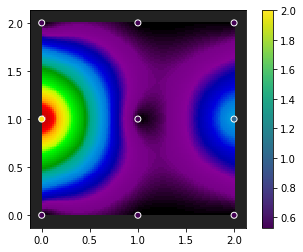

In [52]:
from scipy import interpolate

x = dsplot.x
y = dsplot.y
z = dsplot.density
xx = np.linspace(x.min(), x.max(), 100)
yy = np.linspace(y.min(), y.max(), 100)
X,Y = np.meshgrid(xx,yy)

### Add some noise to prevent singular matrix in interpolate
dr = 0.0001
xr = x + np.random.uniform(-dr, dr, size=x.shape)
yr = y + np.random.uniform(-dr, dr, size=y.shape)
rbf = interpolate.Rbf(xr,yr,z, function='linear')
#rbf = interpolate.Rbf(x,y,z, function='cubic')
#rbf = interpolate.RectBivariateSpline(x,y,z)
Z = rbf(X,Y)

ax = plt.imshow(Z, vmin=z.min(), vmax=z.max(), origin='lower',
          extent=[x.min(), x.max(), y.min(), y.max()])
ax.set_cmap('nipy_spectral')
plt.scatter(x, y, c=z, edgecolors='#ffffff')
ax.axes.set_facecolor('#222222')
plt.colorbar()

for rxn in B_cell.reactions.query('EX_'):
    if rxn.x < -1e-3:
        print('%s:\t %s <= %s <= %s' % (rxn.id, rxn.lower_bound, rxn.x, rxn.upper_bound))